# Guide d'utilisation de Grad-CAM avec TensorFlow

Ce notebook explique comment utiliser Grad-CAM (Gradient-weighted Class Activation Mapping) pour visualiser quelles parties d'une image sont importantes pour la classification par un modèle de deep learning.

## 1. Introduction

Grad-CAM est une technique de visualisation qui permet de comprendre pourquoi un réseau de neurones convolutif a pris une décision particulière. Elle génère une carte de chaleur qui met en évidence les régions de l'image qui ont le plus influencé la prédiction du modèle.

## 2. Configuration de l'environnement

Commençons par importer les bibliothèques nécessaires :


In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.cm as cm


## 3. Chargement du modèle

Nous pouvons utiliser différents modèles pré-entraînés. Voici comment les charger :


In [7]:
def load_model(model_name="xception", weights="imagenet"):
    """
    Charge un modèle pré-entraîné.
    """
    model_name = model_name.lower()
    model_mapping = {
        "xception": keras.applications.xception.Xception,
        "resnet50": keras.applications.resnet50.ResNet50,
        "mobilenet": keras.applications.mobilenet.MobileNet,
    }

    if model_name in model_mapping:
        return model_mapping[model_name](weights=weights)
    else:
        raise ValueError(f"Modèle non supporté : {model_name}")


## 4. Prétraitement des images

Pour que les images soient compatibles avec nos modèles, nous devons les prétraiter :


In [8]:
def load_and_preprocess_image(img_path, img_size, preprocessing_function):
    """
    Charge et prétraite une image.
    """
    img = keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocessing_function(img_array)
    return img_array


## 5. Création de la carte de chaleur Grad-CAM

Le cœur de la méthode Grad-CAM :


In [9]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names, pred_index=None):
    """
    Calcule la carte de chaleur Grad-CAM.
    """
    # Obtenir la dernière couche de convolution
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Créer un modèle pour les couches de classification
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Calculer les gradients
    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)

        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, pred_index]

    # Calculer les gradients par rapport à la dernière couche de convolution
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Pondérer les cartes de caractéristiques
    last_conv_layer_output = last_conv_layer_output[0].numpy()
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # Générer la carte de chaleur
    heatmap = np.mean(last_conv_layer_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8

    return heatmap


## 6. Génération de rapports

Pour mieux comprendre les prédictions du modèle, nous pouvons générer un rapport détaillé :


In [13]:
def get_decode_predictions_function(model_name="xception"):
    """
    Retourne la fonction decode_predictions appropriée pour le modèle.
    """
    decode_mapping = {
        "xception": keras.applications.xception.decode_predictions,
        "resnet50": keras.applications.resnet50.decode_predictions,
        "mobilenet": keras.applications.mobilenet.decode_predictions,
    }

    if model_name in decode_mapping:
        return decode_mapping[model_name]
    else:
        raise ValueError(f"decode_predictions non disponible pour {model_name}.")

def generate_report(img_path, model, preprocess_func, img_size):
    """
    Génère un rapport détaillé des prédictions du modèle.

    Args:
        img_path: Chemin vers l'image
        model: Modèle de classification
        preprocess_func: Fonction de prétraitement
        img_size: Taille d'image requise par le modèle
    """
    # Prétraiter l'image
    img_array = load_and_preprocess_image(img_path, img_size, preprocess_func)

    # Obtenir les prédictions
    preds = model.predict(img_array)
    decode_func = get_decode_predictions_function(model.name)
    predictions = decode_func(preds, top=5)[0]

    # Générer le rapport
    print("=" * 50)
    print(f"Rapport d'analyse pour: {os.path.basename(img_path)}")
    print("=" * 50)
    print("\nTop 5 des prédictions:")
    print("-" * 30)

    for i, (class_id, class_name, probability) in enumerate(predictions, 1):
        print(f"{i}. {class_name}")
        print(f"   Probabilité: {probability*100:.2f}%")
        print(f"   ID classe: {class_id}")
        print("-" * 30)

    # Identifier la prédiction la plus confiante
    top_prediction = predictions[0]
    print(f"\nPrédiction principale: {top_prediction[1]}")
    print(f"Confiance: {top_prediction[2]*100:.2f}%")
    print("=" * 50)


## 7. Utilisation complète

Voici comment utiliser toutes ces fonctions ensemble :


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Rapport d'analyse pour: cat.jpg

Top 5 des prédictions:
------------------------------
1. tabby
   Probabilité: 62.60%
   ID classe: n02123045
------------------------------
2. Egyptian_cat
   Probabilité: 16.93%
   ID classe: n02124075
------------------------------
3. tiger_cat
   Probabilité: 11.49%
   ID classe: n02123159
------------------------------
4. window_screen
   Probabilité: 0.37%
   ID classe: n04589890
------------------------------
5. doormat
   Probabilité: 0.11%
   ID classe: n03223299
------------------------------

Prédiction principale: tabby
Confiance: 62.60%


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_950']
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)
<ipython-input-10-77d81d5c20f4>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap(cmap)


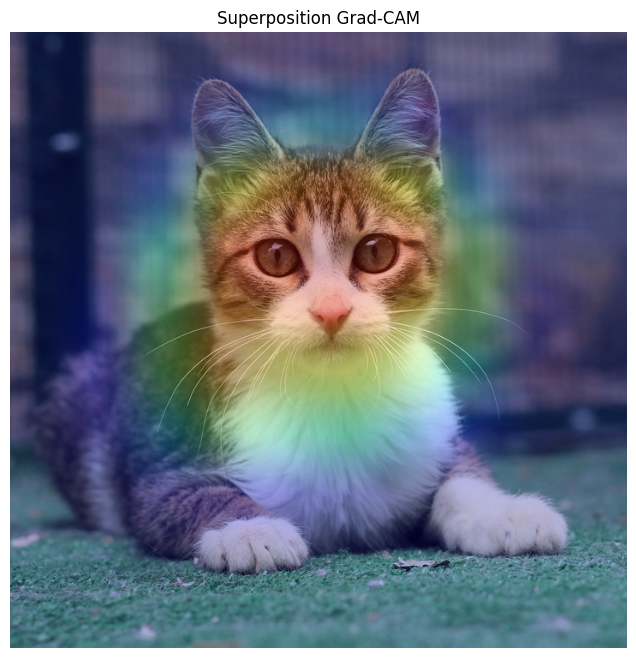

In [15]:
# Configuration
model_name = "xception"
img_path = "cat.jpg"
img_size = (299, 299)  # pour Xception
save_path = "gradcam_output.jpg"

# Charger le modèle
model = load_model(model_name)
preprocess_func = get_preprocessing_function(model_name)

# Générer le rapport de prédictions
generate_report(img_path, model, preprocess_func, img_size)

# Prétraiter l'image pour Grad-CAM
img_array = load_and_preprocess_image(img_path, img_size, preprocess_func)

# Configuration des couches pour Grad-CAM
last_conv_layer_name = "block14_sepconv2_act"  # pour Xception
classifier_layer_names = ["avg_pool", "predictions"]

# Générer la carte de chaleur
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Visualiser les résultats
superimpose_heatmap(img_path, heatmap, save_path=save_path)


## 8. Conclusion

Grad-CAM est un outil indispensable dans l'arsenal de l'apprentissage profond pour plusieurs raisons :

### Interprétabilité
- Permet de "voir à travers" les yeux du modèle en visualisant les régions importantes pour ses décisions
- Aide à vérifier si le modèle se concentre sur les caractéristiques pertinentes de l'image
- Facilite la détection des biais potentiels dans le processus de décision

### Applications pratiques
- **Debugging** : Identification rapide des cas où le modèle se concentre sur des éléments inappropriés
- **Validation** : Confirmation que le modèle utilise des caractéristiques logiques pour ses prédictions
- **Communication** : Permet d'expliquer visuellement les décisions du modèle aux parties prenantes non techniques

### Avantages de cette implémentation
- Compatible avec plusieurs architectures populaires (Xception, ResNet50, MobileNet)
- Facilement extensible à d'autres modèles
- Intègre des fonctionnalités de reporting pour une analyse complète
- Permet la personnalisation des visualisations (alpha, colormap)

### Limites et considérations
- Ne fonctionne qu'avec des modèles CNN ayant des couches de convolution
- La qualité des visualisations dépend de l'architecture du modèle
- Les performances peuvent varier selon la complexité de l'image

### Perspectives d'amélioration
- Intégration d'autres techniques de visualisation (Guided Backprop, Integrated Gradients)
- Ajout de métriques quantitatives pour l'évaluation des zones activées
- Support pour l'analyse par lots (batch processing)
- Extension à d'autres types de tâches (détection d'objets, segmentation)

Cette implémentation fournit une base solide pour comprendre et analyser les décisions des modèles de vision par ordinateur, contribuant ainsi à une IA plus transparente et plus fiable.